# **Step 1: Data Collection & Exploration**

In [ ]:
# Load the Necessary Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import json
import pyarrow.parquet as pq
import re
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')
import textblob
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from category_encoders import TargetEncoder                        # Pip install this module if not loaded automatically as shown in the next cell
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from collections import Counter
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, classification_report
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
import joblib

import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


In [ ]:
pip install category_encoders      # Run it if this line: 'from category_encoders import TargetEncoder' doesnt load automatically then run the above cell again

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 2.9 MB/s eta 0:00:00


In [ ]:
from google.colab import files
uploaded = files.upload()

Saving climate_nasa.csv to climate_nasa.csv


**Data Exploration**

In [ ]:
# Load the dataset
data = pd.read_csv('climate_nasa.csv')
data.head()

,date,likesCount,profileName,commentsCount,text
0,2022-09-07T17:12:32.000Z,2,4dca617d86b3fdce80ba7e81fb16e048c9cd9798cdfd6d...,NaN,Neat comparison I have not heard it before.\n ...
1,2022-09-08T14:51:13.000Z,0,518ab97f2d115ba5b6f03b2fba2ef2b120540c9681288b...,NaN,An excellent way to visualise the invisible! T...
2,2022-09-07T17:19:41.000Z,1,d82e8e24eb633fd625b0aef9b3cb625cfb044ceb8483e1...,3.0,Does the CO2/ghg in the troposphere affect the...
3,2022-09-08T00:51:30.000Z,4,37a509fa0b5177a2233c7e2d0e2b2d6916695fa9fba3f2...,NaN,excellent post! I defo feel the difference - o...
4,2022-09-07T19:06:20.000Z,16,e54fbbd42a729af9d04d9a5cc1f9bbfe8081a31c219ecb...,26.0,"Yes, and carbon dioxide does not harm the Eart..."


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 522 entries, 0 to 521
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           522 non-null    object 
 1   likesCount     522 non-null    int64  
 2   profileName    522 non-null    object 
 3   commentsCount  244 non-null    float64
 4   text           504 non-null    object 
dtypes: float64(1), int64(1), object(3)
memory usage: 20.5+ KB


In [ ]:
data.shape                  # (522, 5)
data.size                  # 2610
data.describe()

,likesCount,commentsCount
count,522.000000,244.000000
mean,4.720307,8.696721
std,12.053556,12.266176
min,0.000000,1.000000
25%,0.000000,2.000000
50%,1.000000,5.000000
75%,4.000000,10.000000
max,126.000000,93.000000


In [ ]:
# Check for missing values
data.isnull().sum()

,0
date,0
likesCount,0
profileName,0
commentsCount,278
text,18


In [ ]:
# Load NASA GISTEMP dataset for advanced climate trend analysis (eg: seasonal breakdowns, extreme event detection)
from google.colab import files
uploaded = files.upload()

Saving GLB.Ts+dSST.csv to GLB.Ts+dSST.csv


In [ ]:
data2 = pd.read_csv('GLB.Ts+dSST.csv', skiprows=1, na_values='***')
data2.head()

,Year,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec,J-D,D-N,DJF,MAM,JJA,SON
0,1880,-0.18,-0.24,-0.09,-0.16,-0.10,-0.21,-0.18,-0.10,-0.14,-0.23,-0.22,-0.17,-0.17,NaN,NaN,-0.12,-0.16,-0.20
1,1881,-0.20,-0.14,0.03,0.05,0.06,-0.19,0.00,-0.03,-0.15,-0.22,-0.18,-0.07,-0.09,-0.09,-0.17,0.05,-0.07,-0.18
2,1882,0.16,0.14,0.04,-0.17,-0.14,-0.23,-0.16,-0.07,-0.14,-0.24,-0.16,-0.36,-0.11,-0.09,0.08,-0.09,-0.15,-0.18
3,1883,-0.29,-0.37,-0.12,-0.18,-0.17,-0.07,-0.06,-0.14,-0.21,-0.11,-0.23,-0.11,-0.17,-0.19,-0.34,-0.15,-0.09,-0.18
4,1884,-0.13,-0.07,-0.35,-0.40,-0.33,-0.35,-0.30,-0.27,-0.27,-0.25,-0.33,-0.31,-0.28,-0.26,-0.10,-0.36,-0.31,-0.28


# **Step 2: Data Cleaning/Preprocessing**


**Data Cleaning/Preprocessing of 'GLB.Ts+dSST' aka 'nasa_monthly_annomalies' dataset**

In [ ]:
# Gather all the months name exclude 'J-D	D-N	DJF	MAM	JJA	SON'
months = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']

# Convert all columns to numeric
data2[months] = data2[months].apply(pd.to_numeric, errors='coerce')

# Keep only Year and Jan–Dec columns
data2 = data2[['Year'] + months]

# Melt into long format
data2_long = data2.melt(id_vars=['Year'], value_vars=months, var_name='Month', value_name='Anomaly')

# Map month names to numbers
month_map = {'Jan': '01', 'Feb':'02', 'Mar':'03', 'Apr':'04', 'May':'05', 'Jun':'06', 'Jul':'07', 'Aug':'08', 'Sep':'09', 'Oct':'10', 'Nov':'11', 'Dec':'12'}
data2_long['Month'] = data2_long['Month'].map(month_map)

# Creating a Date Column
data2_long['year-month'] = pd.to_datetime(data2_long['Year'].astype(str) + '-' + data2_long['Month'])

# Keep only needed columns and sort
data2_long = data2_long[['year-month', 'Anomaly']].sort_values('year-month').reset_index(drop=True)

# Save the csv file
data2_long.to_csv('nasa_monthly_annomalies', index=False)

**Data Cleaning/Preprocessing of 'climate_nasa' dataset**

In [ ]:
data.duplicated().sum()               # No duplicates
data.isnull().sum()                   # commentsCount	- 278 (null values) & text -	18 (null values)

data['commentsCount'] = data['commentsCount'].fillna(0)        # Fill with 0's
data['text'] = data['text'].fillna('')                         # Fill with spaces

print('Missing valuse after cleaning: ', data.isnull().sum())

# Covert 'date' column to datetime format
data['date'] = pd.to_datetime(data['date'])

# Remove 'time' from 'date' column and convert in the first year-month
data['year-month'] = data['date'].dt.to_period('M').dt.to_timestamp()

# Drop 'profileName' column (an unnecessry column in this case)
data = data.drop('profileName',axis=1)

# Cleaned 'data'
data.head(5)

Missing valuse after cleaning:  date             0
likesCount       0
profileName      0
commentsCount    0
text             0
dtype: int64


,date,likesCount,commentsCount,text,year-month
0,2022-09-07 17:12:32+00:00,2,0.0,Neat comparison I have not heard it before.\n ...,2022-09-01
1,2022-09-08 14:51:13+00:00,0,0.0,An excellent way to visualise the invisible! T...,2022-09-01
2,2022-09-07 17:19:41+00:00,1,3.0,Does the CO2/ghg in the troposphere affect the...,2022-09-01
3,2022-09-08 00:51:30+00:00,4,0.0,excellent post! I defo feel the difference - o...,2022-09-01
4,2022-09-07 19:06:20+00:00,16,26.0,"Yes, and carbon dioxide does not harm the Eart...",2022-09-01


**Merge datasets**

In [ ]:
# print(data.columns)
# print(data2_long.columns)

merged_df = pd.merge(data, data2_long, on='year-month', how='left' )
print('Shape of Merged dataset: ','\nRows:',merged_df.shape[0], '\nColumns:',merged_df.shape[1])
merged_df.head()

Shape of Merged dataset:  
Rows: 522 
Columns: 6


,date,likesCount,commentsCount,text,year-month,Anomaly
0,2022-09-07 17:12:32+00:00,2,0.0,Neat comparison I have not heard it before.\n ...,2022-09-01,0.89
1,2022-09-08 14:51:13+00:00,0,0.0,An excellent way to visualise the invisible! T...,2022-09-01,0.89
2,2022-09-07 17:19:41+00:00,1,3.0,Does the CO2/ghg in the troposphere affect the...,2022-09-01,0.89
3,2022-09-08 00:51:30+00:00,4,0.0,excellent post! I defo feel the difference - o...,2022-09-01,0.89
4,2022-09-07 19:06:20+00:00,16,26.0,"Yes, and carbon dioxide does not harm the Eart...",2022-09-01,0.89


In [ ]:
# Saving merged_df as 'df' for efficiency
df = merged_df

**Statistics (Simple)**

In [ ]:
df['likesCount'].describe()

,likesCount
count,522.000000
mean,4.720307
std,12.053556
min,0.000000
25%,0.000000
50%,1.000000
75%,4.000000
max,126.000000


In [ ]:
df['commentsCount'].describe()

,commentsCount
count,522.000000
mean,4.065134
std,9.436095
min,0.000000
25%,0.000000
50%,0.000000
75%,4.000000
max,93.000000


In [ ]:
# 'text' column distribution
df['text'] = df['text'].fillna('')             # Ensure text is string
df['text_len'] = df['text'].str.len()          # Stores length of the charcters
df['text_len'].describe()

,text_len
count,522.000000
mean,179.038314
std,519.980262
min,0.000000
25%,37.000000
50%,88.500000
75%,176.000000
max,7649.000000


# **Step: 3 Exploratory Data Analysis (EDA)**

**Distribution of likes and comments**

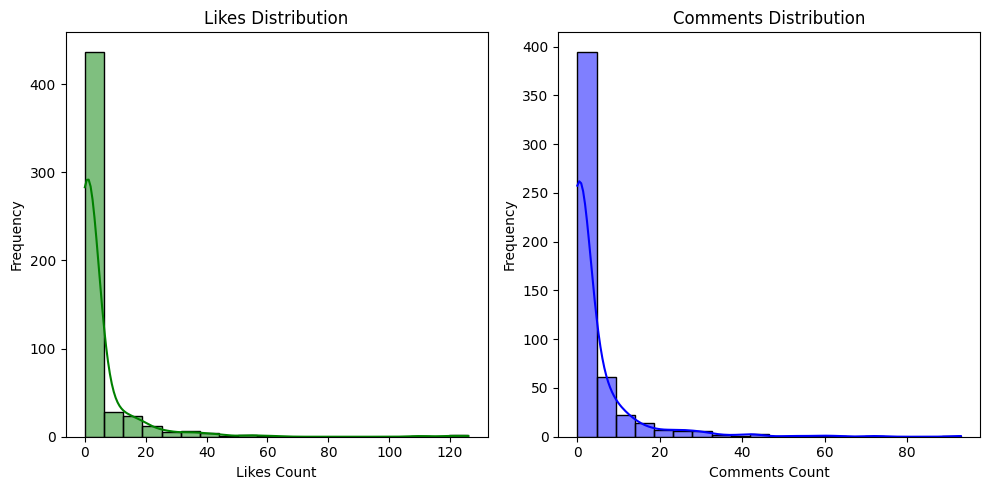

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Distribution of likes
sns.histplot(df['likesCount'], bins=20, color='g', kde=True, ax=axes[0])
axes[0].set_xlabel('Likes Count')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Likes Distribution')


# Distribution of Comments
sns.histplot(df['commentsCount'], bins=20, color='b', kde=True, ax=axes[1])
axes[1].set_xlabel('Comments Count')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Comments Distribution')
plt.tight_layout()
plt.show()

**Time-series trends (Visualization)**

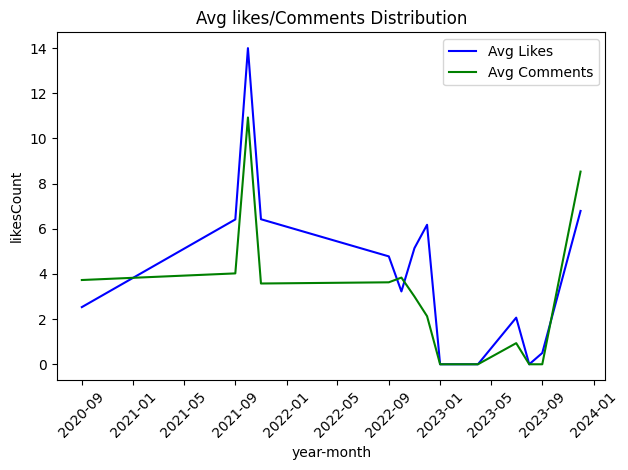

In [ ]:
# Group by year-month and calculate average likes and comments
monthly_stats = df.groupby("year-month")[["likesCount", "commentsCount"]].mean().reset_index()
sns.lineplot(data=monthly_stats, x="year-month", y="likesCount", label='Avg Likes', color='b')
sns.lineplot(data=monthly_stats, x="year-month", y="commentsCount", label='Avg Comments', color='g')
plt.xticks(rotation=45)
plt.title('Avg likes/Comments Distribution')
plt.tight_layout()
plt.show()

**Aggregations by month (Tabular Representation)**

In [ ]:
# monthly counts of post and mean engagement and anomaly
monthly = df.groupby('year-month').agg(
    posts_counts = ('text', 'count'),
    mean_likes = ('likesCount', 'mean'),
    total_likes = ('likesCount', 'sum'),
    mean_comments = ('commentsCount', 'mean'),
    total_comments = ('commentsCount', 'sum'),
    mean_text_len = ('text_len', 'mean'),
    Anomaly = ('Anomaly', 'mean')
).reset_index()

monthly.head()

,year-month,posts_counts,mean_likes,total_likes,mean_comments,total_comments,mean_text_len,Anomaly
0,2020-09-01,160,2.531250,405,3.731250,597.0,145.381250,0.96
1,2021-09-01,82,6.414634,526,4.024390,330.0,147.414634,0.92
2,2021-10-01,14,14.000000,196,10.928571,153.0,178.428571,0.99
3,2021-11-01,26,6.423077,167,3.576923,93.0,168.384615,0.92
4,2022-09-01,27,4.777778,129,3.629630,98.0,87.444444,0.89


**Posts per month and tempreture anomaly distribution**

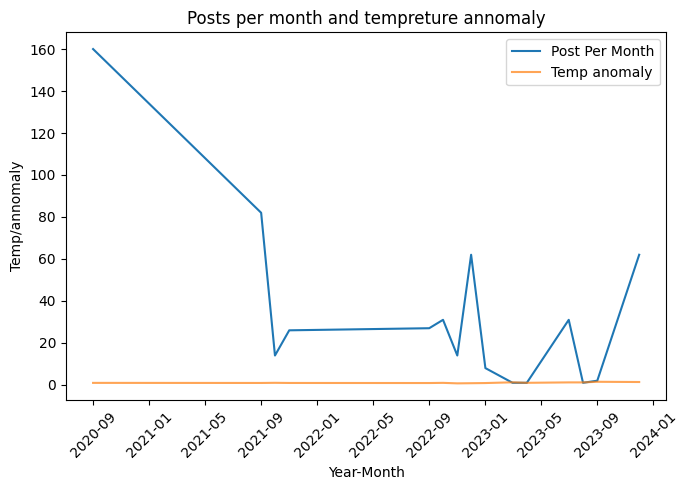

In [ ]:
plt.figure(figsize=(7,5))
plt.plot(monthly['year-month'], monthly['posts_counts'], label='Post Per Month')
plt.plot(monthly['year-month'], monthly['Anomaly'], label='Temp anomaly', alpha=0.7)

plt.xlabel('Year-Month')
plt.ylabel('Temp/annomaly')
plt.xticks(rotation=45)

plt.title('Posts per month and tempreture annomaly')
plt.legend()
plt.tight_layout()
plt.show()

**Annomaly Detection Trends**

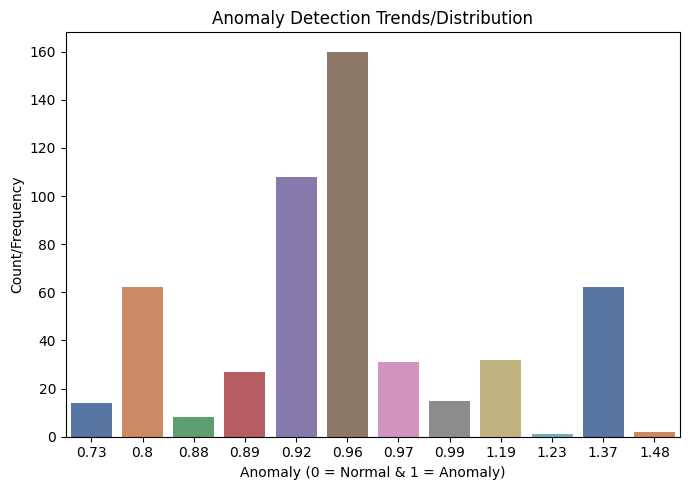

In [ ]:
plt.figure(figsize=(7,5))
sns.countplot(data=df, x='Anomaly', palette='deep')
plt.xlabel('Anomaly (0 = Normal & 1 = Anomaly)')
plt.ylabel('Count/Frequency')
plt.title('Anomaly Detection Trends/Distribution')
plt.tight_layout()
plt.show()

**Correlation Heatmap**

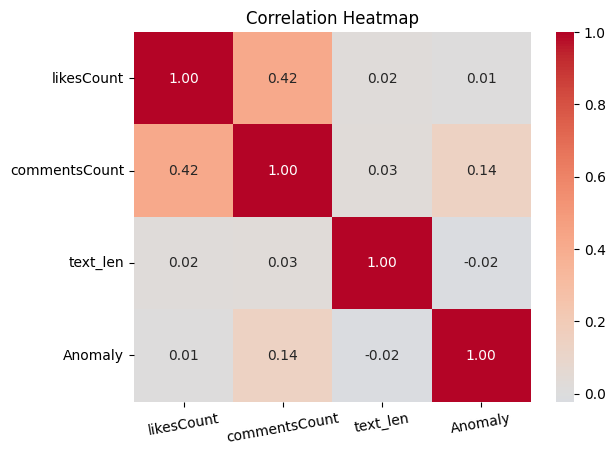

In [ ]:
corr = df[['likesCount', 'commentsCount', 'text_len', 'Anomaly']].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm' ,fmt='.2f', center=0)
plt.xticks(rotation=10)
plt.title('Correlation Heatmap')
plt.show()

**Text Preprocessing**

In [ ]:
# Cleaning 'text' for vectorizer (Conversion to lower case, Removing of url's/wide spaces if any)
def clean_text(text):
  text = text.lower()                          # lower case the sentence
  text = re.sub(r'http\S+|www\.\S+','',text)    # Remove Url's
  text = re.sub(r'\s+',' ',text).strip()        # remove extra wide spaces and newlines
  return text

df['cleaned_text'] = df['text'].fillna('').astype(str).apply(clean_text)
texts = df['cleaned_text'].values

**WorldCloud of Top 50 Words (Unigrams)**

Vocabulary size:  50


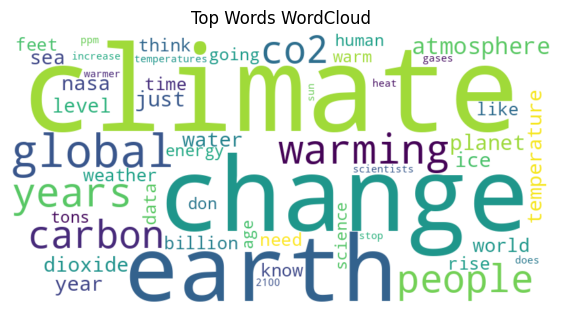

In [ ]:
# Initialize Vectorizer
vectorizer = CountVectorizer(stop_words='english', max_features=50)             # Initialize CountVectorizer - Removes common words like 'the','is', etc

# Fit transform text into document term matrix
X_text = vectorizer.fit_transform(texts)

print('Vocabulary size: ',len(vectorizer.get_feature_names_out()))
# X_text.shape

words_count = np.asarray(X_text.sum(axis=0)).ravel()           # Word counts
vocab = vectorizer.get_feature_names_out()                     # Vocabulary

top_words_df = pd.DataFrame({
    'word':vocab,
    'count':words_count
}).sort_values(by='count',ascending=False).reset_index(drop=True)

# top_words_df.head()
# Dictionary for word frequencies
word_freq = dict(zip(top_words_df['word'], top_words_df['count']))

# Create wordcloud
wc = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_freq)

# Visualize
plt.figure(figsize=(7,5))
plt.imshow(wc, interpolation='Bilinear')
plt.title('Top Words WordCloud')
plt.axis('off')
plt.show()

In [ ]:
# Most Common words as the above wordcloud confirms
top_words_df.head()

,word,count
0,climate,123
1,change,91
2,earth,81
3,global,74
4,warming,68


# **Step 4: Feature Engineering**

**Sentiment Analysis using VADER**

In [ ]:
sia = SentimentIntensityAnalyzer()
df['Sentiment-Score'] = df['cleaned_text'].apply(lambda x: sia.polarity_scores(x)['compound'])
df['Sentiment-label'] = df['Sentiment-Score'].apply(lambda score: 2 if score > 0.05 else (0 if score < -0.05 else 1))

# label_mapping = {'Negative': 0, 'Neutral': 1, 'Positive': 2}
# df['Sentiment-label'] = df['Sentiment-label'].map(label_mapping)

# TextBlob polarity/subjectivity
df['Polarity'] = df['cleaned_text'].apply(lambda x: textblob.TextBlob(str(x)).sentiment.polarity)    # Extracting sentiment polarity (-1 to +1) indicating negative to positive tone
df['Subjectivity'] = df['cleaned_text'].apply(lambda x: textblob.TextBlob(str(x)).sentiment.subjectivity) # Extracting sentiment subjectivity (0 to 1) indicating objective to subjective expression

df.iloc[:5, -4:]    # Displaying the columns

,Sentiment-Score,Sentiment-label,Polarity,Subjectivity
0,0.7702,2,0.000000,0.500000
1,0.7840,2,0.600000,0.600000
2,0.3736,2,0.000000,0.000000
3,0.1759,2,0.053571,0.744048
4,0.6059,2,-0.375000,0.625000


**TF-IDF representation (Text Vectorization)**

In [ ]:
tfidf = TfidfVectorizer(max_features=500)                      # Initialize TF-IDF Vectorizer
tfidf_matrix = tfidf.fit_transform(df['cleaned_text'])         # Parse matrix
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf.get_feature_names_out())         # Create Dataframe
df = pd.concat([df.reset_index(drop=True), tfidf_df.reset_index(drop=True)], axis=1)
df.drop(['text', 'cleaned_text'], axis=1, inplace=True)                               # Dropping columns no longer needed

print('Shape after TF-IDF Vectorizer:',df.shape)
print('\nColumns after TF-IDF Vectorizer:',df.columns)

Shape after TF-IDF Vectorizer: (522, 510)

Columns after TF-IDF Vectorizer: Index(['date', 'likesCount', 'commentsCount', 'year-month', 'Anomaly',
       'text_len', 'Sentiment-Score', 'Sentiment-label', 'Polarity',
       'Subjectivity',
       ...
       'work', 'world', 'would', 'wouldn', 'wow', 'year', 'years', 'yes',
       'you', 'your'],
      dtype='object', length=510)


**Handle class imbalance with SMOTE**

In [ ]:
X_smote = df.drop(['Sentiment-label','Sentiment-Score','date','year-month'], axis=1)   # Features
y_smote = df['Sentiment-label']                                    # target

X_train, X_test, y_train, y_test = train_test_split(X_smote, y_smote, test_size=0.2, stratify=y_smote, random_state=42)
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

print('Before SMOTE:', Counter(y_train))
print('After SMOTE:', Counter(y_resampled))

Before SMOTE: Counter({1: 158, 2: 155, 0: 104})
After SMOTE: Counter({1: 158, 2: 158, 0: 158})


**Lag & Rolling Stats**

In [ ]:
# Rolling avgs of likescounts for past 3 posts
df['likes_count_lag1'] = df['likesCount'].shift(1)   # Shifts 'likescount' column by one row and holds the values of previous rows
df['likescount_rolling_mean3'] = df['likesCount'].rolling(window=3).mean()               # Mean of 3 rolling averages of previous rows

# Hanlde missing values
df[['likes_count_lag1', 'likescount_rolling_mean3']] = df[['likes_count_lag1', 'likescount_rolling_mean3']].fillna(0)

# Interaction trends
df['likes_x_comments'] = df['likesCount'] * df['commentsCount']
df['Sentimet_x_textlen'] = df['Sentiment-Score'] * df['text_len']

**Encoding Categorical Values (Optional)**

In [ ]:
# cat_cols = df.select_dtypes(include=['object']).columns                   # Stores the Categorical columns for Encoding
# cat_cols = [col for col in cat_cols if col not in ['text','cleaned_text']]          # Excluding text columns which are already handled ['text','cleaned_text']
# if cat_cols:                               # Apply target encoding
#   te = TargetEncoder()
#   X_categorical = te.fit_transform(df[cat_cols], df['Sentiment-label'])
# else:
#   X_categorical = pd.DataFrame()

# **Step 5: Model Building**

In [ ]:
# Inspect target distribution and type
print("dtype:", df['Sentiment-label'].dtype)
print("\nUnique values:", sorted(df['Sentiment-label'].dropna().unique().tolist()))
print("\nValue counts:\n", df['Sentiment-label'].value_counts(dropna=False))

dtype: int64

Unique values: [0, 1, 2]

Value counts:
 Sentiment-label
1    198
2    194
0    130
Name: count, dtype: int64


**Train-test split (time-series aware)**

In [ ]:
# Features
X = df.drop(columns=['date', 'year-month', 'Sentiment-label','Sentiment-Score'])
y = df['Sentiment-label']
# train test split
split_index = int(len(df) * 0.8)                                               # split index for 80% train / 20% test
X_train, X_test = X.iloc[ : split_index], X.iloc[split_index : ]
y_train, y_test = y.iloc[ : split_index], y.iloc[split_index : ]

print(f"Train size: {X_train.shape}, Test size: {X_test.shape}")

Train size: (417, 510), Test size: (105, 510)


**Outlier detection**

In [ ]:
iso = IsolationForest(contamination=0.05, random_state=42)
outlier_pred = iso.fit_predict(X_train[numerical_cols])  # -1 = outlier, 1 = inlier

# Keep only inliers in training data
mask_inliers = outlier_pred == 1
X_train = X_train[mask_inliers]
y_train = y_train[mask_inliers]

**Scaling**

In [ ]:
# Scale numerical columns
scaler = StandardScaler()
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

numerical_cols = X_train.select_dtypes(include=[np.number]).columns.tolist()
X_train[numerical_cols] = scaler.fit_transform(X_train[numerical_cols])
X_test[numerical_cols] = scaler.transform(X_test[numerical_cols])

**Model Selection/Training**

In [ ]:
# Liner Regression
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
lr_pred = lr_model.predict(X_test)

# Decision Tree
dt_model = DecisionTreeRegressor(random_state=42)
dt_model.fit(X_train, y_train)
dt_pred = dt_model.predict(X_test)

# Evaluation
def evaluate_model(y_true, y_pred, model_name):
  rmse = np.sqrt(mean_squared_error(y_true, y_pred))
  r2 = r2_score(y_true, y_pred)
  print(f'{model_name} - RMSE: {rmse:.3f}, R2: {r2:.3f}')

**Advanced Models**

In [ ]:
# Random Forest
rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X_train, y_train)
rf_pred = rf_model.predict(X_test)

# XGBoost
xgb_model = XGBRegressor(random_state=42, verbosity=0)
xgb_model.fit(X_train, y_train)
xgb_pred = xgb_model.predict(X_test)

In [ ]:
# Evaluation of all models
evaluate_model(y_test, lr_pred, 'Linear Regression')
evaluate_model(y_test, dt_pred, 'Decision Tree')
evaluate_model(y_test, rf_pred, 'Random Forest')
evaluate_model(y_test, xgb_pred, 'XGBoost' )

Linear Regression - RMSE: 90.136, R2: -11274.539
Decision Tree - RMSE: 0.169, R2: 0.960
Random Forest - RMSE: 0.031, R2: 0.999
XGBoost - RMSE: 0.195, R2: 0.947


**Hyperparameter tuning**

In [ ]:
param_grid = {
    'n_estimators' : [100,200],
    'max_depth' : [5, 10, None],
    'min_samples_split' : [2, 5]
}

grid_search = GridSearchCV(
  RandomForestRegressor(random_state=42),
  param_grid,
  scoring = 'neg_root_mean_squared_error',
  cv = 3,
  verbose = 1
)

grid_search.fit(X_train, y_train)

print(f'Best params: {grid_search.best_params_}')
print(f'Best RMSE: {- grid_search.best_score_:.3f}')

Fitting 3 folds for each of 12 candidates, totalling 36 fits
Best params: {'max_depth': 5, 'min_samples_split': 5, 'n_estimators': 200}
Best RMSE: 0.097


# **Step 7: Model Evaluation & Validation**

**Time Series Cross Validation (time-series split)**

In [ ]:
# Time-series-split (5 folds)
tscv = TimeSeriesSplit(n_splits=5)

def ts_cross_val(model, X, y, model_name):
  scores = cross_val_score(model, X, y, cv=tscv, scoring='neg_mean_squared_error')
  rmse_scores = np.sqrt(-scores)
  print(f'{model_name} - Mean RMSE: {rmse_scores.mean():.4f}, Std: {rmse_scores.std():.4f}')


ts_cross_val(LinearRegression(), X, y, 'Linear Regression')
ts_cross_val(DecisionTreeRegressor(random_state=42), X, y, 'Decision Tree')
ts_cross_val(RandomForestRegressor(random_state=42), X, y, 'Random Forest')
ts_cross_val(XGBRegressor(random_state=42), X, y, 'XGB Regressor')


Linear Regression - Mean RMSE: 72.4723, Std: 79.4410
Decision Tree - Mean RMSE: 0.0957, Std: 0.0832
Random Forest - Mean RMSE: 0.0885, Std: 0.0693
XGB Regressor - Mean RMSE: 0.1142, Std: 0.0942


**Feature importance / SHAP**

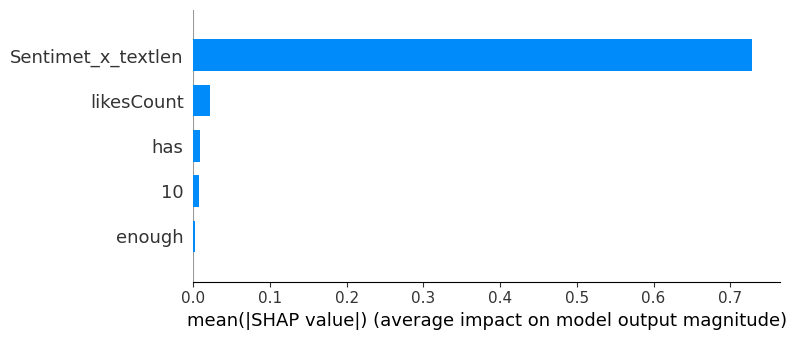

In [ ]:
import shap
explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test, plot_type='bar', max_display=5)

# **Step 8: Model Selection & Saving**

In [ ]:
results = {}

for model, name in zip([lr_model, dt_model, rf_model, xgb_model], ['Linear Regression', 'Decision Tree', 'Random Forest', 'XGBoost']):
  y_pred = model.predict(X_test)
  accuracyScore = accuracy_score(y_test, np.round(y_pred))
  results[name] = accuracyScore

print('Model Comparison Results:')
for k, v in results.items():
  print(f'{k}:{v:.4f}')

best_model_name = max(results, key=results.get)
print(f'Best Model Name: {best_model_name}')

if best_model_name == 'Linear Regression':
  final_model = lr_model
elif best_model_name == 'Decision Tree':
  final_model = dt_model
elif best_model_name == 'Random Forest':
  final_model = rf_model
else:
  final_model = xgb_model

# Save model, scaler, feature columns
joblib.dump(final_model, 'Climate_Change_modelling.pkl')
joblib.dump(tfidf_df, 'tfidf_df.pkl')
joblib.dump(scaler, 'scaler.pkl')
joblib.dump(X.columns.tolist(), 'columns.pkl')

Model Comparison Results:
Linear Regression:0.1429
Decision Tree:0.9714
Random Forest:1.0000
XGBoost:0.9619
Best Model Name: Random Forest


['columns.pkl']

**Download the files (The above saved files)**

In [ ]:
# from google.colab import files
# files.download('Climate_Change_modelling.pkl')
# files.download('tfidf_df.pkl')
# files.download('scaler.pkl')
# files.download('columns.pkl')

# **Results Overview**

| Steps                                 | Key Actions                                                 | Outcomes                                        |
| ------------------------------------ | ----------------------------------------------------------- | ----------------------------------------------- |
| **1. Data Collection & Exploration** | Imported NASA anomalies + social media climate comments     | Two clean datasets prepared                     |
| **2. Data Preprocessing**            | Missing value handling, merging, formatting                 | Unified dataset with numeric + text features    |
| **3. EDA**                           | Trends, anomalies, heatmaps, word clouds                    | Insights into climate shifts + public discourse |
| **4. Feature Engineering**           | VADER Sentiment, TF-IDF, SMOTE, rolling stats               | Balanced & enriched feature space               |
| **5. Model Building**                | Train-test split, outlier handling, scaling, model training | Candidate models ready                          |
| **6. Evaluation & Validation**       | Cross-validation, SHAP, feature importance                  | Best-performing models selected                 |
| **7. Model Saving**                  | Final models stored for deployment                          | Models ready for API integration                |



 **Model Performance Summary**

| Model                 | RMSE (Train/Test) | R² (Train/Test) | Time-Series CV (Mean ± Std RMSE) | Notes                      |
| --------------------- | ----------------- | --------------- | -------------------------------- | -------------------------- |
| **Linear Regression** | 90.136            | -11274.539      | 72.4723 ± 79.4410                | Poor performance, underfit |
| **Decision Tree**     | 0.169             | 0.960           | 0.0957 ± 0.0832                  | Strong baseline            |
| **Random Forest**     | 0.031             | 0.999           | 0.0885 ± 0.0693                  | ✅ Best Model (saved)       |
| **XGBoost**           | 0.195             | 0.947           | 0.1142 ± 0.0942                  | Good, slightly behind RF   |





---

# **Project Summary**

In this project, we analyzed **climate change** using both **NASA climate anomalies data** and **Social media comments (Facebook dataset)**

The workflow covered everything from data collection to model deployment readiness, combining time-series analysis, sentiment analysis, and predictive modeling.

**Key highlights:**

- Cleaned and merged two heterogeneous datasets (numerical climate anomalies + textual comments).

- Conducted EDA to uncover patterns in engagement, anomalies, and climate signals.

- Applied feature engineering with sentiment, TF-IDF, rolling statistics, and SMOTE.

- Built multiple models with scaling, tuning, and time-series cross-validation.

- Evaluated models with accuracy metrics, feature importance, and SHAP values.